In [18]:
from functions import (prep, folding, inbu, LSTM_model,setting)
import numpy as np
from matplotlib import pyplot as plt
from keras.models import load_model
from jellyfish import damerau_levenshtein_distance, levenshtein_distance
import pandas as pd
import distance
from sklearn import metrics
np.random.seed(42)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
setting_inputs = setting.inputdef()
csvname = f"{setting_inputs['flatten_by']}_complete" if setting_inputs['complete'] else f"{setting_inputs['flatten_by']}_filter"
# Define model_file based on single_log value
model_file = f"{csvname}_single" if setting_inputs['single_log'] else f"{csvname}_enriched"

Settings:
flatten_by: Orders
single_log: False
complete: False
Add customer: False
Normalize: True
Position excluded: False



In [20]:
setting_inputs

{'source': 'running-example',
 'add_customer': 0,
 'normalize': True,
 'pos_ex': False,
 'flatten_by': 'Orders',
 'single_log': False,
 'complete': False}

In [21]:
# prep the ocel and reading
ocel, act_dict, cust_dict = prep.prep_ocel_complete(setting_inputs=setting_inputs,csvname=csvname)
ocel_train, ocel_test = folding.folding_train_test(ocel, csvname= model_file)
## define some static variables 
divisor = np.mean(ocel['Time_Diff'])  # average time between events
divisor2 = np.mean(ocel['Time_Since_Start'])  # average time between current and first events
divisorTR = np.mean(ocel['Remaining_Time'])  # average time instance remaining
divisor3 = ocel.groupby('Case_ID')['Time_Since_Start'].apply(lambda x: (x.iloc[-1] - x).mean()).mean()

print(f"\ndivisor: {divisor}")
print(f"divisor2: {divisor2}")
print(f"divisorTR: {divisorTR}")
print(f"divisor3: {divisor3}")
print(f'Amount of rows of the OCEL: {len(ocel)}\n')

num_of_features, max_trace_length, act_feat,cust_feat, target_act_feat, target_act_feat_dict, other_features = setting.feature_dimensios(ocel=ocel,setting_input=setting_inputs)
number_of_train_cases = len(ocel_train)
target_act_length = len(target_act_feat)
print(f"Number of train cases: {number_of_train_cases}, Max trace length: {max_trace_length}, Number of features: {num_of_features}\n")


{'place order': 'A', 'confirm order': 'B', 'pay order': 'C', 'payment reminder': 'D'}
{'Marco Pegoraro': 'a', 'Gyunam Park': 'b', 'Majid Rafiei': 'c', 'Junxiong Gao': 'd', 'Seran Uysal': 'e', 'Christina Rensinghof': 'f', 'Wil van der Aalst': 'g', 'Christine Dobbert': 'h', 'Luis Santos': 'i', 'Kefang Ding': 'j', 'Mohammadreza Fani Sani': 'k', 'Tobias Brockhoff': 'l', 'Anahita Farhang Ghahfarokhi': 'm', 'Mahnaz Qafari': 'n', 'Claudia Graf': 'o', 'Mahsa Bafrani': 'p', 'Lisa Mannel': 'q'}

divisor: 318986.03791832976
divisor2: 528541.2252072459
divisorTR: 679045.650752226
divisor3: 591967.807807143
Amount of rows of the OCEL: 6514

Length of act_feat: 4, Length of cust_feat: 0
Number of train cases: 4366, Max trace length: 9, Number of features: 10



In [22]:
ocel['Amount_Items']

0       4
1       4
2       4
3       4
4       4
       ..
6509    5
6510    5
6511    1
6512    1
6513    1
Name: Amount_Items, Length: 6514, dtype: int64

In [23]:
X_train,y_train_a, y_train_t, y_train_tr = inbu.generating_inputs(ocel_fold=ocel_train,ocel=ocel,setting_input=setting_inputs,
                                                                  dn= divisor, ds= divisor2, dr= divisorTR)

print(f"Shape of X_train: {X_train.shape}")
print(f"This matches the desired shape (number_of_train_cases, max_trace_length, num_of_features): {(number_of_train_cases, max_trace_length, num_of_features)} => {X_train.shape ==(number_of_train_cases, max_trace_length, num_of_features)}")
print(f"Shape of y_train_a: {y_train_a.shape}, this matches the desired shape (number_of_train_cases, target_act_length): {(number_of_train_cases, target_act_length)} => {y_train_a.shape ==(number_of_train_cases, target_act_length)}")
print(f"Shape of y_train_t: {y_train_t.shape}, this matches the desired shape (number_of_train_cases, ): {(number_of_train_cases, )} => {y_train_t.shape ==(number_of_train_cases, )}")
print(f"Shape of y_train_tr: {y_train_tr.shape}, this matches the desired shape (number_of_train_cases, ): {(number_of_train_cases, )} => {y_train_tr.shape ==(number_of_train_cases, )}\n")


Length of act_feat: 4, Length of cust_feat: 0
Shape of X_train: (4366, 9, 10)
This matches the desired shape (number_of_train_cases, max_trace_length, num_of_features): (4366, 9, 10) => True
Shape of y_train_a: (4366, 5), this matches the desired shape (number_of_train_cases, target_act_length): (4366, 5) => True
Shape of y_train_t: (4366,), this matches the desired shape (number_of_train_cases, ): (4366,) => True
Shape of y_train_tr: (4366,), this matches the desired shape (number_of_train_cases, ): (4366,) => True



In [24]:
print(f'For the following setting a model is now trained {model_file}\n')
history, best_model_name, early_stopping= LSTM_model.LSTM_MODEL(X_train, y_train_a, y_train_t, y_train_tr,filename=model_file)

For the following setting a model is now trained Orders_filter_enriched

Build model...
Epoch 1/500
388/388 - 8s - loss: 1.8974 - act_output_loss: 0.5035 - time_output_loss: 0.8990 - timeR_output_loss: 0.4949 - val_loss: 1.3779 - val_act_output_loss: 0.2146 - val_time_output_loss: 0.7155 - val_timeR_output_loss: 0.4478
Epoch 2/500
388/388 - 3s - loss: 1.5106 - act_output_loss: 0.2603 - time_output_loss: 0.7893 - timeR_output_loss: 0.4610 - val_loss: 1.3153 - val_act_output_loss: 0.1926 - val_time_output_loss: 0.6867 - val_timeR_output_loss: 0.4360
Epoch 3/500
388/388 - 3s - loss: 1.4812 - act_output_loss: 0.2490 - time_output_loss: 0.7745 - timeR_output_loss: 0.4578 - val_loss: 1.3081 - val_act_output_loss: 0.1930 - val_time_output_loss: 0.6792 - val_timeR_output_loss: 0.4359
Epoch 4/500
388/388 - 3s - loss: 1.4658 - act_output_loss: 0.2429 - time_output_loss: 0.7676 - timeR_output_loss: 0.4553 - val_loss: 1.3381 - val_act_output_loss: 0.1925 - val_time_output_loss: 0.6855 - val_timeR_

The best value for the validation loss is  1.2935938835144043 and was archived at the epoch 66



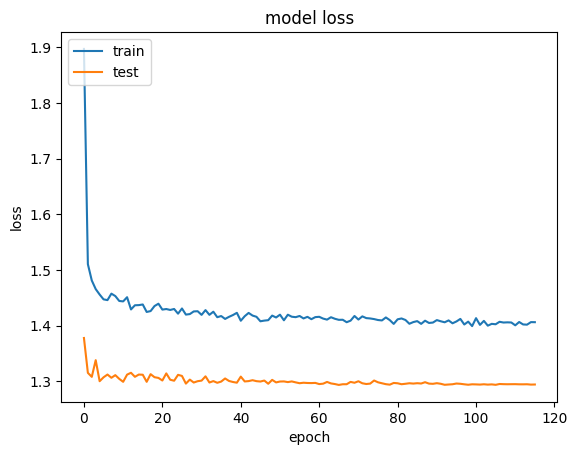

The best model has the name model_Orders_filter_enriched_66-1.29.h5



In [25]:
val_loss = min(history.history['val_loss'])
val_loss2 = best_model_name.best
epoch = early_stopping.stopped_epoch - 49
print(f'The best value for the validation loss is  {val_loss} and was archived at the epoch {epoch}\n')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

modelname = 'model_' + model_file + f"_{epoch:02d}-{val_loss:.2f}.h5"

print(f'The best model has the name {modelname}\n')

In [26]:
model = load_model(f'./output_files/models/{modelname}')
X_test, y_test_a, y_test_t, y_test_tr = inbu.generating_inputs(ocel_fold=ocel_test,ocel=ocel,setting_input=setting_inputs,
                                                                  dn= divisor, ds= divisor2, dr= divisorTR)

# y_t = y_t * divisor3
y = model.predict(X_test,verbose=1)
y_char = y[0][:][:]
y_t = y[1][:][:]
y_tr = y[2][:][:]
max_index_list = [np.argmax(pred) for pred in y_char]
pred_act_list = [target_act_feat_dict.get(item, item) for item in max_index_list]
y_t = np.maximum(y_t, 0)
y_t1 = y_t * divisor
y_tr1 = y_tr * divisorTR

columns_to_drop = [col for col in ocel_test.columns if 'Act_' in col] + \
                [col for col in ocel_test.columns if 'Cust_' in col] + \
                ['Customers', 'Next_Time_Since_Start',
                'Next_Time_Since_Midnight', 'Next_Weekday',
                'Position', 'Time_Since_Midnight', 'Weekday'] + other_features

columns_to_drop_existing = [col for col in columns_to_drop if col in ocel_test.columns]
output_ocel = ocel_test.drop(columns=columns_to_drop_existing).copy()
output_ocel['Pred_Activity'] = pred_act_list
output_ocel['Pred_Time_Diff'] = y_t1
output_ocel['Pred_Remaining_Time'] = y_tr1

output_ocel['Levenshtein'] = output_ocel.apply(lambda row: 1 - levenshtein_distance(row['Pred_Activity'], row['Next_Activity']), axis=1)
output_ocel['Damerau'] = output_ocel.apply(lambda row: 1 - (damerau_levenshtein_distance(row['Pred_Activity'], row['Next_Activity']) / max(len(row['Pred_Activity']), len(row['Next_Activity']))), axis=1)
output_ocel['Damerau'] = output_ocel['Damerau'].clip(lower=0)
output_ocel['Jaccard'] = output_ocel.apply(lambda row: 1 - distance.jaccard(row['Pred_Activity'], row['Next_Activity']), axis=1)

act_comp = output_ocel['Pred_Activity'] == output_ocel['Next_Activity'] 
print(f'The accuracy of the activation prediction is {sum(act_comp)/len(act_comp)}')
MAE_Time_diff = metrics.mean_absolute_error(output_ocel['Pred_Time_Diff']/ (24 * 60 * 60),output_ocel['Next_Time_Diff']/ (24 * 60 * 60))
MAE_rem_time = metrics.mean_absolute_error(output_ocel['Pred_Remaining_Time']/ (24 * 60 * 60),output_ocel['Next_Remaining_Time']/ (24 * 60 * 60))
RMSE_Time_diff = metrics.mean_squared_error(output_ocel['Pred_Time_Diff']/ (24 * 60 * 60),output_ocel['Next_Time_Diff']/ (24 * 60 * 60),squared=False)
RMSE_rem_time = metrics.mean_squared_error(output_ocel['Pred_Remaining_Time']/ (24 * 60 * 60),output_ocel['Next_Remaining_Time']/ (24 * 60 * 60),squared=False)
print(f'MAE of the time between events in days {MAE_Time_diff}')
print(f'MAE of the remaining time in days {MAE_rem_time}')
# print(f'RMSE of the time between events in days {RMSE_Time_diff}')
# print(f'RMSE of the remaining time in days {RMSE_rem_time}')

Length of act_feat: 4, Length of cust_feat: 0
68/68 [==============================] - 1s 4ms/step
The accuracy of the activation prediction is 0.9301675977653632
MAE of the time between events in days 2.6067039267816017
MAE of the remaining time in days 3.1924718954642093


In [ ]:
output_ocel

In [27]:
prefix_lengths = range(2, max_trace_length-1)  # List of prefix lengths to consider
results = []

for prefix_length in prefix_lengths:
    print(f"Results for Prefix Length {prefix_length}:")
    
    # Generate inputs with the current prefix length
    X_test,y_test_a, y_test_t, y_test_tr = inbu.generating_inputs(ocel_fold=ocel_test,ocel=ocel,setting_input=setting_inputs,
                                                                  dn= divisor, ds= divisor2, dr= divisorTR,
                                                                    prefix_length=prefix_length)
    # Make predictions with the model
    y = model.predict(X_test, verbose=1)
    y_char = y[0][:][:]
    y_t = y[1][:][:]
    y_tr = y[2][:][:]

    max_index_list = [np.argmax(pred) for pred in y_char]
    pred_act_list = [target_act_feat_dict.get(item, item) for item in max_index_list]
    y_t = np.maximum(y_t, 0)
    y_t1 = y_t * divisor
    y_tr1 = y_tr * divisorTR

    columns_to_drop = [col for col in ocel_test.columns if 'Act_' in col] + \
                    [col for col in ocel_test.columns if 'Cust_' in col] + \
                    ['Customers', 'Next_Time_Since_Start',
                    'Next_Time_Since_Midnight', 'Next_Weekday',
                    'Position', 'Time_Since_Midnight', 'Weekday'] + other_features

    columns_to_drop_existing = [col for col in columns_to_drop if col in ocel_test.columns]
    trace_length = ocel_test['Trace_Len'].values
    output_ocel = ocel_test[trace_length >= prefix_length].reset_index(drop= True).drop(columns=columns_to_drop_existing).copy()
    output_ocel['Pred_Activity'] = pred_act_list
    output_ocel['Pred_Time_Diff'] = y_t1
    output_ocel['Pred_Remaining_Time'] = y_tr1

    output_ocel['Levenshtein'] = output_ocel.apply(lambda row: 1 - levenshtein_distance(row['Pred_Activity'], row['Next_Activity']), axis=1)
    output_ocel['Damerau'] = output_ocel.apply(lambda row: 1 - (damerau_levenshtein_distance(row['Pred_Activity'], row['Next_Activity']) / max(len(row['Pred_Activity']), len(row['Next_Activity']))), axis=1)
    output_ocel['Damerau'] = output_ocel['Damerau'].clip(lower=0)
    output_ocel['Jaccard'] = output_ocel.apply(lambda row: 1 - distance.jaccard(row['Pred_Activity'], row['Next_Activity']), axis=1)

    mae_time_diff = metrics.mean_absolute_error(output_ocel['Pred_Time_Diff']/ (24 * 60 * 60), output_ocel['Next_Time_Diff']/ (24 * 60 * 60)) 
    mae_remaining_time = metrics.mean_absolute_error(output_ocel['Pred_Remaining_Time']/ (24 * 60 * 60), output_ocel['Next_Remaining_Time']/ (24 * 60 * 60)) 
    rmse_time_diff = metrics.mean_squared_error(output_ocel['Pred_Time_Diff']/ (24 * 60 * 60), output_ocel['Next_Time_Diff']/ (24 * 60 * 60), squared=False) 
    rmse_remaining_time = metrics.mean_squared_error(output_ocel['Pred_Remaining_Time']/ (24 * 60 * 60), output_ocel['Next_Remaining_Time']/ (24 * 60 * 60), squared=False) 

    # Store the results for the current prefix length
    results.append({
        'Prefix Length': prefix_length,
        'length': len(y_tr),
        'MAE Time Difference': mae_time_diff,
        'MAE Remaining Time': mae_remaining_time,
        'RMSE Time Difference': rmse_time_diff,
        'RMSE Remaining Time': rmse_remaining_time
    })

    # Output additional values based on Case_ID and prefix length
    for case_id in output_ocel['Case_ID'].unique():
        case_data = output_ocel[output_ocel['Case_ID'] == case_id]
        trace_length = len(case_data)
        if prefix_length <= trace_length:
            # print(f"\nAdditional values for Prefix Length {prefix_length} and Case ID {case_id}:")
            case_data_prefix = case_data[:prefix_length]
            #print(case_data_prefix.to_string(index=False))
            
            mae_time_diff_case = metrics.mean_absolute_error(case_data_prefix['Pred_Time_Diff']/ (24 * 60 * 60), case_data_prefix['Next_Time_Diff']/ (24 * 60 * 60))
            mae_remaining_time_case = metrics.mean_absolute_error(case_data_prefix['Pred_Remaining_Time']/ (24 * 60 * 60), case_data_prefix['Next_Remaining_Time']/ (24 * 60 * 60))
            rmse_time_diff_case = metrics.mean_squared_error(case_data_prefix['Pred_Time_Diff']/ (24 * 60 * 60), case_data_prefix['Next_Time_Diff']/ (24 * 60 * 60), squared=False)
            rmse_remaining_time_case = metrics.mean_squared_error(case_data_prefix['Pred_Remaining_Time']/ (24 * 60 * 60), case_data_prefix['Next_Remaining_Time']/ (24 * 60 * 60), squared=False)
            
            # print(f"\nMetrics for Prefix Length {prefix_length} and Case ID {case_id}:")
            # print("MAE Time Difference:", mae_time_diff_case)
            # print("MAE Remaining Time:", mae_remaining_time_case)
            # print("RMSE Time Difference:", rmse_time_diff_case)
            # print("RMSE Remaining Time:", rmse_remaining_time_case)

# Output the overall results
df_results = pd.DataFrame(results)
print("\nOverall Results:")
print(df_results)


Results for Prefix Length 2:
Length of act_feat: 4, Length of cust_feat: 0
68/68 [==============================] - 1s 2ms/step
Results for Prefix Length 3:
Length of act_feat: 4, Length of cust_feat: 0
68/68 [==============================] - 0s 3ms/step
Results for Prefix Length 4:
Length of act_feat: 4, Length of cust_feat: 0
16/16 [==============================] - 0s 4ms/step
Results for Prefix Length 5:
Length of act_feat: 4, Length of cust_feat: 0
4/4 [==============================] - 0s 4ms/step
Results for Prefix Length 6:
Length of act_feat: 4, Length of cust_feat: 0
1/1 [==============================] - 0s 21ms/step
Results for Prefix Length 7:
Length of act_feat: 4, Length of cust_feat: 0
1/1 [==============================] - 0s 19ms/step

Overall Results:
   Prefix Length  length  MAE Time Difference  MAE Remaining Time  \
0              2    2148             2.622205            3.188847   
1              3    2148             2.618409            3.172671   
2          

In [ ]:
import pickle
modelname = ""
# Load the saved history from file
with open(f'/ouput_files/history/{modelname}_history.pkl', 'rb') as file:
    loaded_history = pickle.load(file)

# Access the loaded history
print(loaded_history)
plt.plot(loaded_history['loss'])
plt.plot(loaded_history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()